# Premier League Shot Creation & FPL Performance Analysis

Welcome to an in-depth analysis of Premier League player creativity and efficiency, with a focus on shot and goal creation. This notebook explores:

- **SCA90**: Shot creation actions per 90 minutes
- **TO**: Take-ons for shot creation
- **Age**: Player age
- **Pos**: Player position

**Key Objectives:**
- Calculate take-on dependency ratios (TO/SCA) and SCA90 rankings
- Visualize SCA90 vs take-on dependency (scatter plot, colored by position, sized by age)
- Perform correlation and statistical analysis of creative output by position and age
- Identify the most efficient creators using a composite score
- Explore age-related trends and peak creative years
- Use unsupervised clustering to reveal player creativity archetypes

---


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal
from sklearn.preprocessing import LabelEncoder
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import r2_score

In [3]:
# Load dataset
shot_df = pd.read_csv('Shot_Creation.csv')

# Preview relevant columns
shot_df[['Player', 'Pos', 'Age', 'SCA', 'SCA90', 'TO']].head()

,Player,Pos,Age,SCA,SCA90,TO
0,Mohamed Salah,FW,32-342,164,4.50,22
1,Virgil van Dijk,DF,33-319,48,1.33,1
2,Ryan Gravenberch,MF,23-007,66,1.92,5
3,Alexis Mac Allister,MF,26-150,120,4.15,2
4,Ibrahima Konaté,DF,25-363,31,1.12,0


In [4]:
# Clean and convert columns
shot_df['SCA'] = pd.to_numeric(shot_df['SCA'], errors='coerce')
shot_df['SCA90'] = pd.to_numeric(shot_df['SCA90'], errors='coerce')
shot_df['TO'] = pd.to_numeric(shot_df['TO'], errors='coerce')
shot_df['Age'] = shot_df['Age'].str.extract(r'(\d{2})').astype(float)

# Calculate take-on dependency ratio
shot_df['TO_SCA_ratio'] = shot_df['TO'] / shot_df['SCA']

# SCA90 ranking
shot_df['SCA90_rank'] = shot_df['SCA90'].rank(ascending=False, method='min')

# Drop rows with missing values in key columns
shot_df = shot_df.dropna(subset=['SCA', 'SCA90', 'TO', 'TO_SCA_ratio', 'Age'])

# Remove 'Squad Total' and 'Opponent Total' rows from the data
shot_df = shot_df[~shot_df['Player'].str.contains('Squad Total|Opponent Total', case=False, na=False)]

# Preview new columns
shot_df[['Player', 'Pos', 'Age', 'SCA', 'SCA90', 'TO', 'TO_SCA_ratio', 'SCA90_rank']].head()

,Player,Pos,Age,SCA,SCA90,TO,TO_SCA_ratio,SCA90_rank
0,Mohamed Salah,FW,32.0,164,4.50,22,0.134146,90.0
1,Virgil van Dijk,DF,33.0,48,1.33,1,0.020833,396.0
2,Ryan Gravenberch,MF,23.0,66,1.92,5,0.075758,297.0
3,Alexis Mac Allister,MF,26.0,120,4.15,2,0.016667,103.0
4,Ibrahima Konaté,DF,25.0,31,1.12,0,0.000000,429.0


In [5]:
# Interactive scatter plot: SCA90 vs Take-on Dependency
# Apply thresholding ONLY for this plot
min_sca = 20  # Increase threshold
min_sca90 = 4.0  # Increase threshold
plot_df = shot_df[(shot_df['SCA'] >= min_sca) & (shot_df['SCA90'] >= min_sca90)]

fig = px.scatter(
    plot_df,
    x='TO_SCA_ratio',
    y='SCA90',
    color='Pos',
    size='Age',
    hover_data=['Player', 'SCA', 'TO', 'SCA90', 'TO_SCA_ratio', 'Age', 'Pos'],
    labels={'TO_SCA_ratio': 'Take-on Dependency Ratio (TO/SCA)', 'SCA90': 'SCA per 90'},
    title='SCA90 vs Take-on Dependency Ratio by Position and Age',
    height=600
)
fig.show()

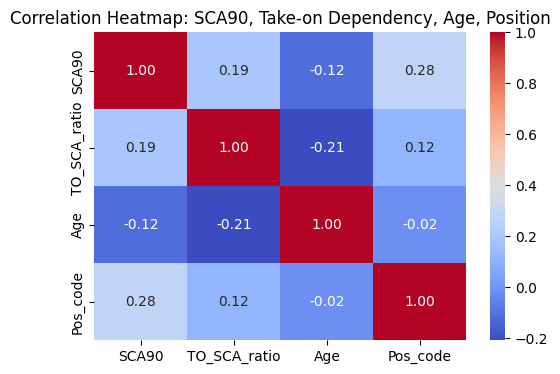

In [6]:
# Correlation analysis between SCA90, TO_SCA_ratio, Age, and position (encoded numerically)
corr_df = shot_df.copy()
corr_df['Pos_code'] = LabelEncoder().fit_transform(corr_df['Pos'])
corr = corr_df[['SCA90', 'TO_SCA_ratio', 'Age', 'Pos_code']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap: SCA90, Take-on Dependency, Age, Position')
plt.show()

In [7]:
# Composite efficiency score: high SCA90, low TO_SCA_ratio, and diversity (1-TO_SCA_ratio)
shot_df['efficiency_score'] = (
    (shot_df['SCA90'] / shot_df['SCA90'].max()) * 0.6 +
    ((1 - shot_df['TO_SCA_ratio']) / (1 - shot_df['TO_SCA_ratio']).max()) * 0.4
)
# Rank by efficiency
shot_df['efficiency_rank'] = shot_df['efficiency_score'].rank(ascending=False, method='min')

top20 = shot_df.nsmallest(20, 'efficiency_rank')[['Player', 'Pos', 'Age', 'SCA90', 'TO_SCA_ratio', 'efficiency_score', 'efficiency_rank']]
display(top20)

,Player,Pos,Age,SCA90,TO_SCA_ratio,efficiency_score,efficiency_rank
225,Jakub Moder,MF,26.0,32.73,0.000000,1.000000,1.0
405,Chiquinho,MF,25.0,25.71,0.000000,0.871311,2.0
347,Asher Agbinone,MF,19.0,15.00,0.000000,0.674977,3.0
49,Takehiro Tomiyasu,DF,26.0,12.86,0.000000,0.635747,4.0
607,Carlos Alcaraz,MF,22.0,9.00,0.000000,0.564986,5.0
310,Philip Billing,MF,28.0,7.83,0.000000,0.543538,6.0
605,Samuel Amo-Ameyaw,"FW,DF",18.0,6.43,0.000000,0.517874,7.0
533,Odsonne Édouard,FW,27.0,6.21,0.000000,0.513841,8.0
280,Willian,"FW,MF",36.0,5.93,0.000000,0.508708,9.0
603,Samuel Edozie,"DF,FW",22.0,5.54,0.000000,0.501558,10.0


In [8]:
# Statistical summary by position
pos_summary = shot_df.groupby('Pos').agg(
    avg_SCA90=('SCA90', 'mean'),
    avg_TO_SCA_ratio=('TO_SCA_ratio', 'mean'),
    count=('Player', 'count')
).reset_index()
display(pos_summary)

,Pos,avg_SCA90,avg_TO_SCA_ratio,count
0,DF,1.448598,0.025454,164
1,"DF,FW",3.084000,0.032468,5
2,"DF,MF",1.905294,0.018747,17
3,FW,2.815405,0.100344,74
4,"FW,DF",3.043333,0.028935,6
5,"FW,MF",3.323509,0.089832,57
6,GK,0.251379,0.000000,29
7,MF,3.471500,0.030195,100
8,"MF,DF",2.553333,0.053700,12
9,"MF,FW",3.453810,0.086733,42


In [9]:
# Significance testing for SCA90 by position
anova = f_oneway(*[group['SCA90'].values for name, group in shot_df.groupby('Pos')])
print('ANOVA F-statistic:', anova.statistic, 'p-value:', anova.pvalue)
if anova.pvalue < 0.05:
    print('Significant difference in SCA90 between positions.')
else:
    print('No significant difference in SCA90 between positions.')

# Significance testing for TO_SCA_ratio by position
kruskal_test = kruskal(*[group['TO_SCA_ratio'].values for name, group in shot_df.groupby('Pos')])
print('Kruskal-Wallis H-statistic:', kruskal_test.statistic, 'p-value:', kruskal_test.pvalue)
if kruskal_test.pvalue < 0.05:
    print('Significant difference in take-on dependency between positions.')
else:
    print('No significant difference in take-on dependency between positions.')

ANOVA F-statistic: 11.434527451031009 p-value: 2.371292666056353e-16
Significant difference in SCA90 between positions.
Kruskal-Wallis H-statistic: 133.20461740897224 p-value: 2.5979314968909896e-24
Significant difference in take-on dependency between positions.


# Age-Related Trends in Shot and Goal Creation

This section investigates how creative output (SCA90 and GCA90) varies with player age and position. We aim to:
- Identify peak creative years for different positions
- Understand how shot and goal creation efficiency evolves over a player's career
- Visualize and statistically test age-related trends in creative performance

## Data Preparation and Age Binning

- Convert SCA90, GCA90, and Age columns to numeric types for analysis.
- Bin players into age groups: 18-21, 22-25, 26-29, 30-33, and 34+.
- These bins allow for grouped analysis of performance by age cohort.

In [10]:
# --- Data Preparation and Binning ---
# Ensure numeric types for SCA90, GCA90, Age
shot_df['SCA90'] = pd.to_numeric(shot_df['SCA90'], errors='coerce')
shot_df['GCA90'] = pd.to_numeric(shot_df['GCA90'], errors='coerce')
shot_df['Age'] = pd.to_numeric(shot_df['Age'], errors='coerce')

# Define age bins and labels
age_bins = [17, 21, 25, 29, 33, 100]
age_labels = ['18-21', '22-25', '26-29', '30-33', '34+']
shot_df['age_group'] = pd.cut(shot_df['Age'], bins=age_bins, labels=age_labels, right=True)

## Grouped Means by Age Group and Position

- Calculate the mean SCA90 and GCA90 for each age group and position.
- This provides a summary of creative output by both age and role on the pitch.

In [11]:
# --- Grouped Means by Age Group and Position ---
age_pos_summary = shot_df.groupby(['age_group', 'Pos']).agg(
    mean_SCA90=('SCA90', 'mean'),
    mean_GCA90=('GCA90', 'mean'),
    count=('Player', 'count')
).reset_index()

C:\Users\omara\AppData\Local\Temp\ipykernel_11020\433299929.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Multi-Line Plots: Age Curves by Position

- Visualize the mean SCA90 and GCA90 for each position across age groups.
- These plots help identify trends and potential peak ages for creative output by position.

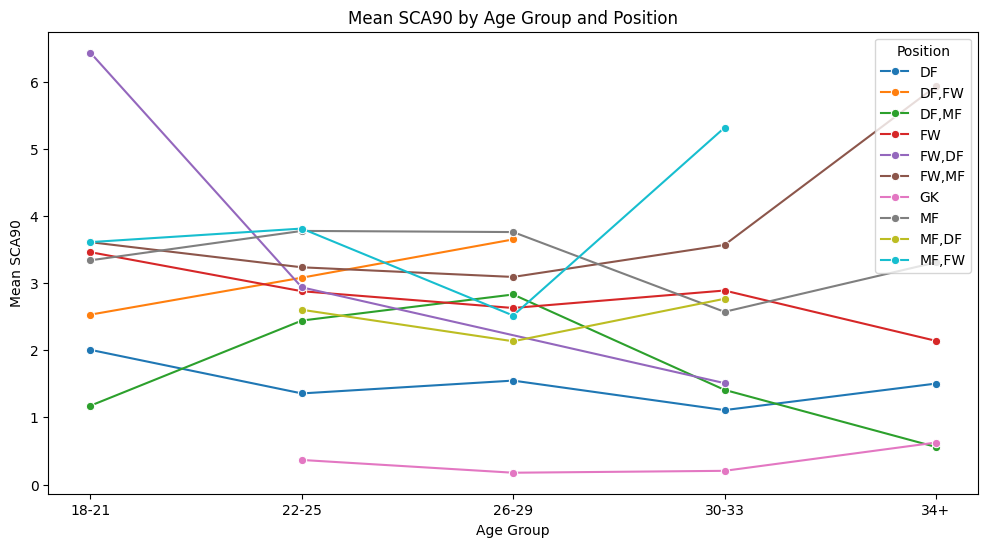

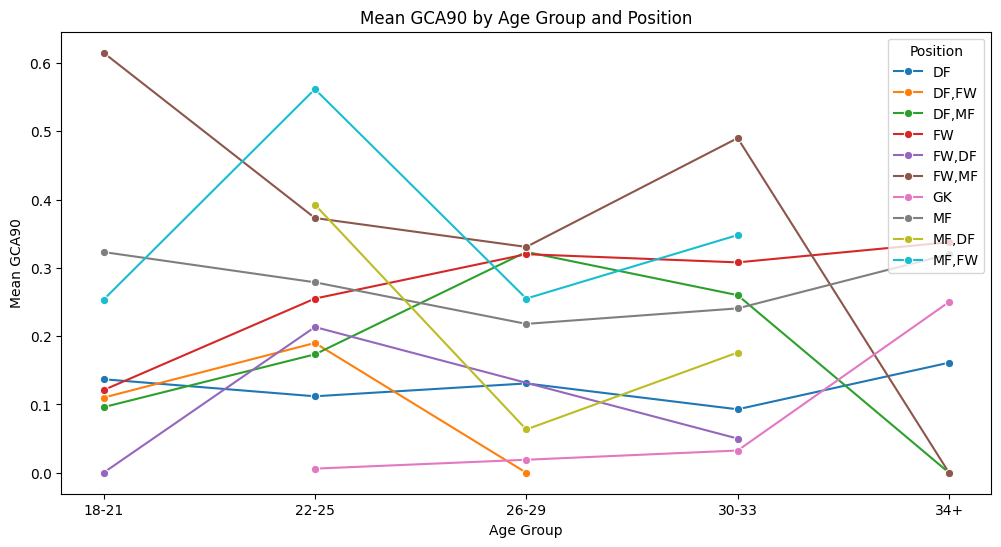

In [12]:
# --- Multi-Line Plots: Age Curves by Position ---
plt.figure(figsize=(12, 6))
sns.lineplot(data=age_pos_summary, x='age_group', y='mean_SCA90', hue='Pos', marker='o')
plt.title('Mean SCA90 by Age Group and Position')
plt.ylabel('Mean SCA90')
plt.xlabel('Age Group')
plt.legend(title='Position')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=age_pos_summary, x='age_group', y='mean_GCA90', hue='Pos', marker='o')
plt.title('Mean GCA90 by Age Group and Position')
plt.ylabel('Mean GCA90')
plt.xlabel('Age Group')
plt.legend(title='Position')
plt.show()

## SCA to GCA Conversion Efficiency by Age Group

- Calculate the ratio of mean GCA90 to mean SCA90 for each age group and position.
- This metric shows how efficiently shot creation actions are converted into goal creation actions as players age.

In [13]:
# --- SCA to GCA Conversion Efficiency by Age Group
conv_eff = age_pos_summary.copy()
# Filter out rows where mean_SCA90 is zero or NaN to avoid NaN/infinite conversion efficiency
conv_eff = conv_eff[conv_eff['mean_SCA90'].notna() & (conv_eff['mean_SCA90'] > 0)]
conv_eff['conversion_efficiency'] = conv_eff['mean_GCA90'] / conv_eff['mean_SCA90']
display(conv_eff[['age_group', 'Pos', 'conversion_efficiency']])

,age_group,Pos,conversion_efficiency
0,18-21,DF,0.068246
1,18-21,"DF,FW",0.043478
2,18-21,"DF,MF",0.081772
3,18-21,FW,0.034971
4,18-21,"FW,DF",0.000000
5,18-21,"FW,MF",0.170419
7,18-21,MF,0.096784
9,18-21,"MF,FW",0.070175
10,22-25,DF,0.082493
11,22-25,"DF,FW",0.061688


## Statistical Testing: Age Effects

- Perform ANOVA tests to determine if there are statistically significant differences in SCA90 and GCA90 across age groups.
- Significant results indicate that age has a measurable effect on creative output.

In [14]:
# --- Statistical Testing: Age Effects ---
sca90_groups = [group['SCA90'].dropna().values for name, group in shot_df.groupby('age_group')]
gca90_groups = [group['GCA90'].dropna().values for name, group in shot_df.groupby('age_group')]
sca90_anova = f_oneway(*sca90_groups)
gca90_anova = f_oneway(*gca90_groups)
print('SCA90 ANOVA: F =', sca90_anova.statistic, 'p =', sca90_anova.pvalue)
print('GCA90 ANOVA: F =', gca90_anova.statistic, 'p =', gca90_anova.pvalue)
if sca90_anova.pvalue < 0.05:
    print('Significant age effect on SCA90')
else:
    print('No significant age effect on SCA90')
if(gca90_anova.pvalue < 0.05):
    print('Significant age effect on GCA90')
else:
    print('No significant age effect on GCA90')

SCA90 ANOVA: F = 1.8531038376354363 p = 0.11745949341715274
GCA90 ANOVA: F = 1.0776958400575571 p = 0.3668178216610143
No significant age effect on SCA90
No significant age effect on GCA90


C:\Users\omara\AppData\Local\Temp\ipykernel_11020\1318204490.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\omara\AppData\Local\Temp\ipykernel_11020\1318204490.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



# Unsupervised Clustering: Player Creativity Archetypes

In this section, we use unsupervised machine learning to uncover distinct creativity archetypes among Premier League players. By clustering players based on detailed shot and goal creation breakdowns, we:

- Visualize player creativity profiles using t-SNE
- Assign each cluster a unique archetype (Set-piece Specialists, Take-on Creators, Hybrid Creators)
- Profile each archetype and provide real player examples

This approach helps clubs, analysts, and fans understand the diversity of creative styles in the league.

In [15]:
# --- Prepare Data for Clustering (Robust to Data Changes) ---
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

# Define SCA and GCA breakdown columns (ensure columns exist in shot_df)
sca_cols = [col for col in ['PassLive', 'PassDead', 'TO', 'Sh', 'Fld', 'Def'] if col in shot_df.columns]
gca_cols = [col for col in ['PassLive.1', 'PassDead.1', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1'] if col in shot_df.columns]

# Filter out players with missing or zero creative actions across all selected variables
clust_cols = sca_cols + gca_cols
creativity_df = shot_df.dropna(subset=clust_cols)
creativity_df = creativity_df[(creativity_df[clust_cols].sum(axis=1) > 0)]

# Standardize the creative action variables
scaler = StandardScaler()
X = scaler.fit_transform(creativity_df[clust_cols])

## Determining Optimal Number of Clusters

We use the elbow method (inertia plot) and silhouette analysis to select the optimal number of clusters for K-means.

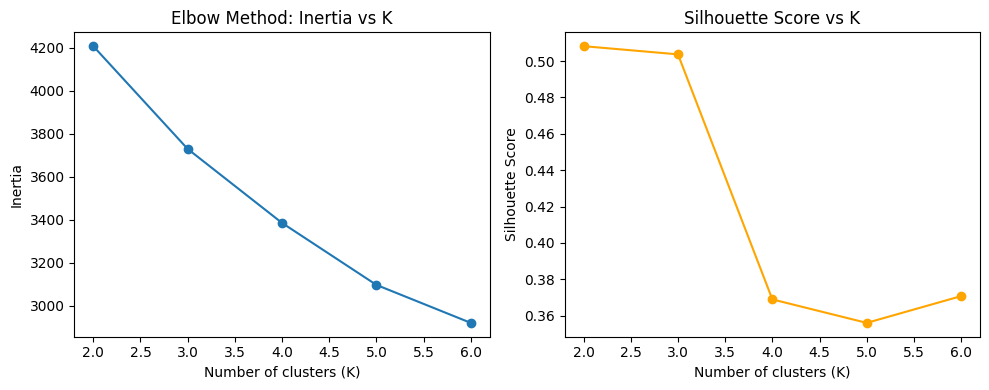

Optimal K (for archetypes): 3


In [16]:
# --- Elbow and Silhouette Analysis (Robust) ---
inertias = []
silhouettes = []
K_range = range(2, 7)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method: Inertia vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(K_range, silhouettes, marker='o', color='orange')
plt.title('Silhouette Score vs K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

optimal_k = 3
print(f"Optimal K (for archetypes): {optimal_k}")

## K-means Clustering and t-SNE Visualization

We apply K-means clustering with K=3 and use t-SNE to visualize clusters in 2D space.

In [17]:
# --- K-means Clustering and t-SNE (Robust, Interactive, 10% Sample for Plot) ---
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
creativity_df['cluster'] = kmeans.fit_predict(X)

# t-SNE for 2D visualization
X_tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(X)
creativity_df['TSNE1'] = X_tsne[:,0]
creativity_df['TSNE2'] = X_tsne[:,1]

# Take a 10% random sample for plotting only (do not affect rest of analysis)
plot_sample = creativity_df.sample(frac=0.3, random_state=42) if len(creativity_df) > 20 else creativity_df

# Interactive plot with player names on hover (10% sample)
import plotly.express as px
fig = px.scatter(
    plot_sample,
    x='TSNE1',
    y='TSNE2',
    color=plot_sample['cluster'].astype(str),
    hover_data=['Player', 'Pos', 'Age'],
    title='t-SNE Scatter Plot of Player Creativity Clusters',
    labels={'color': 'Cluster'},
    symbol=plot_sample['cluster'].astype(str)
)
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

## Cluster Profiling: Mean SCA and GCA Breakdown

For each cluster, we compute the mean values of the six SCA and six GCA methods. This table reveals the creative signature of each archetype—look for which actions (e.g., set-pieces, take-ons) dominate in each group.

In [18]:
# --- Cluster Profiling Table (Robust) ---
cluster_profiles = creativity_df.groupby('cluster')[clust_cols].mean().round(2)
display(cluster_profiles)

,PassLive,PassDead,TO,Sh,Fld,Def,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1
cluster,,,,,,,,,,,,
0,14.94,1.16,0.73,1.14,0.62,0.37,1.36,0.09,0.06,0.15,0.07,0.04
1,56.73,2.23,7.11,5.84,4.59,1.41,6.89,0.06,1.13,0.70,0.84,0.23
2,63.71,17.38,4.07,4.67,3.36,1.21,7.40,1.90,0.43,0.67,0.29,0.14


## Assigning Unique Archetype Names to Clusters

Each cluster is assigned a unique archetype label based on its dominant creative method:

- **Set-piece Specialists**: Highest set-piece (PassDead) involvement
- **Take-on Creators**: Highest take-on (TO) involvement
- **Hybrid Creators**: Balanced or mixed creative profile

This mapping provides actionable insight into player roles and creative tendencies.

In [19]:
# --- Assign Unique Archetype Names to Clusters (Robust) ---
archetype_labels = ['Set-piece Specialists', 'Take-on Creators', 'Hybrid Creators']

# Use PassDead/PassDead.1 for set-piece, TO/TO.1 for take-on, else hybrid
means = cluster_profiles.copy()
means['PassDead_total'] = means.get('PassDead', 0) + means.get('PassDead.1', 0)
means['TO_total'] = means.get('TO', 0) + means.get('TO.1', 0)

set_piece_idx = means['PassDead_total'].idxmax() if 'PassDead_total' in means else 0
takeon_idx = means['TO_total'].idxmax() if 'TO_total' in means else 1
hybrid_idx = list(set(range(optimal_k)) - {set_piece_idx, takeon_idx})[0]

cluster_archetype_map = {
    set_piece_idx: 'Set-piece Specialists',
    takeon_idx: 'Take-on Creators',
    hybrid_idx: 'Hybrid Creators'
}

cluster_profiles['Archetype'] = cluster_profiles.index.map(cluster_archetype_map)
creativity_df['Archetype'] = creativity_df['cluster'].map(cluster_archetype_map)
display(cluster_profiles[['Archetype'] + clust_cols])

,Archetype,PassLive,PassDead,TO,Sh,Fld,Def,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1
cluster,,,,,,,,,,,,,
0,Hybrid Creators,14.94,1.16,0.73,1.14,0.62,0.37,1.36,0.09,0.06,0.15,0.07,0.04
1,Take-on Creators,56.73,2.23,7.11,5.84,4.59,1.41,6.89,0.06,1.13,0.70,0.84,0.23
2,Set-piece Specialists,63.71,17.38,4.07,4.67,3.36,1.21,7.40,1.90,0.43,0.67,0.29,0.14


In [20]:
# --- SCA→GCA Conversion Efficiency by Cluster (Robust) ---
cluster_totals = creativity_df.groupby('cluster')[clust_cols].sum()
sca_total = cluster_totals[sca_cols].sum(axis=1)
gca_total = cluster_totals[gca_cols].sum(axis=1)
conversion_efficiency = gca_total / sca_total
conversion_table = pd.DataFrame({
    'SCA_total': sca_total,
    'GCA_total': gca_total,
    'conversion_efficiency': conversion_efficiency,
    'Archetype': cluster_profiles['Archetype']
})
display(conversion_table)

,SCA_total,GCA_total,conversion_efficiency,Archetype
cluster,,,,
0,7475,694,0.092843,Hybrid Creators
1,5454,689,0.126329,Take-on Creators
2,3965,455,0.114754,Set-piece Specialists


In [21]:
## Player Examples by Archetype

# --- Player Examples by Cluster (Robust) ---
example_cols = ['Player', 'Pos', 'Age'] + clust_cols
examples = []
for i in range(optimal_k):
    cluster_players = creativity_df[creativity_df['cluster']==i]
    sample = cluster_players[example_cols].head(3).copy()
    sample['Archetype'] = cluster_profiles.loc[i, 'Archetype']
    examples.append(sample)
example_df = pd.concat(examples, ignore_index=True)
display(example_df)

,Player,Pos,Age,PassLive,PassDead,TO,Sh,Fld,Def,PassLive.1,PassDead.1,TO.1,Sh.1,Fld.1,Def.1,Archetype
0,Virgil van Dijk,DF,33.0,41,0,1,3,1,2,4,0,0,0,0,0,Hybrid Creators
1,Ryan Gravenberch,MF,23.0,58,0,5,2,0,1,6,0,0,0,0,0,Hybrid Creators
2,Ibrahima Konaté,DF,25.0,26,0,0,4,0,1,6,0,0,0,0,1,Hybrid Creators
3,Mohamed Salah,FW,32.0,119,2,22,14,5,2,20,0,5,2,0,0,Take-on Creators
4,Luis Díaz,FW,28.0,88,0,16,9,4,0,13,0,1,0,2,0,Take-on Creators
5,Cody Gakpo,FW,26.0,55,0,9,5,5,2,3,0,3,0,1,0,Take-on Creators
6,Alexis Mac Allister,MF,26.0,83,24,2,6,2,3,10,3,0,2,0,0,Set-piece Specialists
7,Dominik Szoboszlai,MF,24.0,88,7,5,13,3,1,12,1,0,3,0,0,Set-piece Specialists
8,Trent Alexander-Arnold,DF,26.0,73,14,4,4,0,0,9,1,0,0,0,0,Set-piece Specialists


In [22]:
# --- Interactive scatter plot: SCA90 vs Take-on Dependency
fig = px.scatter(
    plot_df,
    x='TO_SCA_ratio',
    y='SCA90',
    color='Pos',
    size='Age',
    hover_data=['Player', 'SCA', 'TO', 'SCA90', 'TO_SCA_ratio', 'Age', 'Pos'],
    labels={'TO_SCA_ratio': 'Take-on Dependency Ratio (TO/SCA)', 'SCA90': 'SCA per 90'},
    title='SCA90 vs Take-on Dependency Ratio by Position and Age',
    height=600
)
fig.show()

# Tactical Flexibility Indices: Shot and Goal Creation

This section introduces tactical flexibility indices for both shot creation (SCA) and goal creation (GCA), quantifying a player's method variety and adaptability using weighted Shannon entropy. We analyze the relationship between SCA and GCA flexibility, identify player specializations, and provide position-specific benchmarks and recommendations.

In [40]:
# --- Tactical Flexibility Indices: Volume-Adjusted (Favor High Volume) Weighted Shannon Entropy for SCA and GCA ---
from scipy.stats import entropy

# Define SCA and GCA method columns (robust to data changes)
sca_cols = [col for col in ['PassLive', 'PassDead', 'TO', 'Sh', 'Fld', 'Def'] if col in shot_df.columns]
gca_cols = [col for col in ['PassLive.1', 'PassDead.1', 'TO.1', 'Sh.1', 'Fld.1', 'Def.1'] if col in shot_df.columns]

# Assign tactical weights (example: set-piece/pass dead = 1.3, take-on = 1.2, others = 1.0)
sca_weights = np.array([
    1.1 if 'PassLive' in c else 1.2 if 'TO' in c else 1.3 if 'PassDead' in c else 1.0 for c in sca_cols
])
gca_weights = np.array([
    1.1 if 'PassLive.1' in c else 1.2 if 'TO.1' in c else 1.3 if 'PassDead.1' in c else 1.0 for c in gca_cols
])

def weighted_entropy_volume_favor_high(row, cols, weights, total_actions_col=None, alpha=0.2):
    vals = row[cols].values.astype(float)
    total = vals.sum()
    if total == 0 or np.all(vals == 0):
        return 0.0
    # Weighted probabilities: multiply, then renormalize
    probs = vals / total
    weighted_probs = probs * weights
    if weighted_probs.sum() == 0:
        return 0.0
    weighted_probs = weighted_probs / weighted_probs.sum()
    weighted_probs = weighted_probs[weighted_probs > 0]
    ent = entropy(weighted_probs, base=2)
    # Volume adjustment: slightly boost entropy for high-volume players
    if total_actions_col is not None:
        total_actions = row[total_actions_col]
        # Use log scale: higher boost for high volume, minimal for low volume
        volume_factor = 1 + alpha * (np.log1p(total_actions) / (1 + np.log1p(total_actions)))
        ent = ent * volume_factor
    return ent

# Calculate flexibility indices for each player (favor high volume slightly)
shot_df['SCA_flex'] = shot_df.apply(
    lambda r: weighted_entropy_volume_favor_high(r, sca_cols, sca_weights, total_actions_col='SCA', alpha=0.3), axis=1
)
shot_df['GCA_flex'] = shot_df.apply(
    lambda r: weighted_entropy_volume_favor_high(r, gca_cols, gca_weights, total_actions_col='GCA', alpha=0.3) if 'GCA' in shot_df.columns else weighted_entropy_volume_favor_high(r, gca_cols, gca_weights, alpha=0.2), axis=1
)

## Dual Flexibility Ranking and Quadrant Analysis

We rank players by both SCA and GCA flexibility, visualize their relationship, and highlight quadrant-based tactical archetypes (e.g., flexible in SCA but specialized in GCA).

In [41]:
# --- Dual Flexibility Ranking and Quadrant Analysis ---
# Remove players with no SCA or GCA actions
flex_df = shot_df[(shot_df['SCA_flex'] > 0) & (shot_df['GCA_flex'] > 0)].copy()

# Rank by flexibility
flex_df['SCA_flex_rank'] = flex_df['SCA_flex'].rank(ascending=False, method='min')
flex_df['GCA_flex_rank'] = flex_df['GCA_flex'].rank(ascending=False, method='min')

# Scatter plot with quadrant analysis
sca_med = flex_df['SCA_flex'].median()
gca_med = flex_df['GCA_flex'].median()

fig = px.scatter(
    flex_df,
    x='SCA_flex',
    y='GCA_flex',
    color='Pos',
    hover_data=['Player', 'SCA_flex_rank', 'GCA_flex_rank', 'SCA90', 'GCA90'],
    title='SCA Flexibility vs GCA Flexibility (Quadrant Analysis)',
    labels={'SCA_flex': 'SCA Flexibility (Entropy)', 'GCA_flex': 'GCA Flexibility (Entropy)'}
)
# Add quadrant lines
fig.add_shape(type='line', x0=sca_med, x1=sca_med, y0=flex_df['GCA_flex'].min(), y1=flex_df['GCA_flex'].max(), line=dict(dash='dash', color='gray'))
fig.add_shape(type='line', y0=gca_med, y1=gca_med, x0=flex_df['SCA_flex'].min(), x1=flex_df['SCA_flex'].max(), line=dict(dash='dash', color='gray'))
fig.show()

## Tactical Adaptability Framework & Player Archetypes

- **Quadrant I (Top-Right):** Q1: "All-Phase Flex Stars" (versatile)
- **Quadrant II (Top-Left):** Q2: "Flexible Build-Up, Limited Final Ball"
- **Quadrant III (Bottom-Left):** Q3: "Low Flex in Both"
- **Quadrant IV (Bottom-Right):** Q4: "Flexible Final Ball, Limited Build-Up"

We identify and recommend players for each archetype.

In [38]:
# --- Identify Player Archetypes by Flexibility Quadrant ---
def quadrant(row):
    if row['SCA_flex'] >= sca_med and row['GCA_flex'] >= gca_med:
        return 'Versatile'
    elif row['SCA_flex'] >= sca_med and row['GCA_flex'] < gca_med:
        return 'SCA-Flexible, GCA-Specialist'
    elif row['SCA_flex'] < sca_med and row['GCA_flex'] < gca_med:
        return 'Specialist'
    else:
        return 'SCA-Specialist, GCA-Flexible'

flex_df['Flex_Archetype'] = flex_df.apply(quadrant, axis=1)

# Show top 3 players for each archetype
archetype_examples = flex_df.groupby('Flex_Archetype').apply(lambda g: g.nlargest(3, 'SCA90'))
archetype_examples = archetype_examples[['Player', 'Pos', 'SCA_flex', 'GCA_flex', 'SCA90', 'GCA90', 'Flex_Archetype']]
display(archetype_examples)

C:\Users\omara\AppData\Local\Temp\ipykernel_11020\2677172647.py:15: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Player    Pos  SCA_flex  GCA_flex  \
Flex_Archetype                                                                 
SCA-Flexible, GCA-Specialist 64   Kevin De Bruyne  MF,FW  1.749440  1.010729   
                             162  Marcus Rashford     FW  2.219755  1.000147   
                             476    Son Heung-min     FW  1.563837  0.756747   
SCA-Specialist, GCA-Flexible 72     Jack Grealish  FW,MF  0.923833  1.102891   
                             338      Romain Esse     MF  1.205449  1.764674   
                             244   Mathias Jensen     MF  1.180252  1.712757   
Specialist                   215     Brajan Gruda  MF,FW  1.322480  0.874064   
                             33   Martin Ødegaard     MF  1.147554  0.989945   
                             66       Jeremy Doku  FW,MF  1.334225  0.922679   
Versatile                    36       Bukayo Saka  FW,MF  1.963739  1.871529   
                             111      Cole Palmer     MF  1.907863  1.402681   
                             62             Sávio  FW,MF  1.625876  1.755392   

                                  SCA90  GCA90                Flex_Archetype  
Flex_Archetype                                                                
SCA-Flexible, GCA-Specialist 64    5.99   0.58  SCA-Flexible, GCA-Specialist  
                             162   5.49   0.61  SCA-Flexible, GCA-Specialist  
                             476   4.99   0.64  SCA-Flexible, GCA-Specialist  
SCA-Specialist, GCA-Flexible 72    5.86   0.25  SCA-Specialist, GCA-Flexible  
                             338   5.63   2.11  SCA-Specialist, GCA-Flexible  
                             244   4.23   0.53  SCA-Specialist, GCA-Flexible  
Specialist                   215   5.14   0.73                    Specialist  
                             33    4.80   0.66                    Specialist  
                             66    4.62   0.81                    Specialist  
Versatile                    36    5.93   1.22                     Versatile  
                             111   5.81   0.44                     Versatile  
                             62    5.71   0.77                     Versatile

## Position-Specific Flexibility Benchmarks

We compute median flexibility for each position and creation type, providing tactical benchmarks for player evaluation.

In [26]:
# --- Position-Specific Flexibility Benchmarks ---
pos_benchmarks = flex_df.groupby('Pos').agg(
    SCA_flex_median=('SCA_flex', 'median'),
    GCA_flex_median=('GCA_flex', 'median'),
    count=('Player', 'count')
).reset_index()
display(pos_benchmarks)

,Pos,SCA_flex_median,GCA_flex_median,count
0,DF,0.986976,0.918296,53
1,"DF,FW",1.328630,0.766603,2
2,"DF,MF",1.339625,1.171355,3
3,FW,1.410066,1.211157,42
4,"FW,MF",1.234900,1.000000,37
5,GK,0.650022,0.994030,1
6,MF,1.185090,0.954434,49
7,"MF,DF",0.864690,1.386488,6
8,"MF,FW",1.439915,1.122836,22


## Correlation of Flexibility with Performance

We analyze how SCA and GCA flexibility relate to overall creative output (SCA90, GCA90) and efficiency.

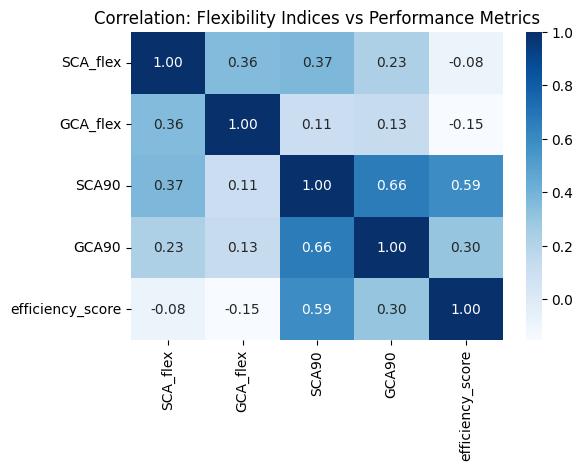

In [27]:
# --- Correlate Flexibility Indices with Performance Metrics ---
perf_corr = flex_df[['SCA_flex', 'GCA_flex', 'SCA90', 'GCA90', 'efficiency_score']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(perf_corr, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation: Flexibility Indices vs Performance Metrics')
plt.show()